In [102]:
import glob
import os
import pickle
import types

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from phd.feature_search.core.models import MultipleLinear
from phd.streaming_rl.core.algorithms.stream_ac import Critic, StreamAC, Normal
from phd.streaming_rl.core.processing import AddTimeInfo, NormalizeObservation, ScaleReward
from phd.streaming_rl.core.obgd import ObGD

In [ ]:
def agent_env_interaction(
        env_name = 'Ant-v4',
        seed = 0,
        lr = 1.0,
        gamma = 0.99,
        lamda = 0.8,
        total_steps = 2_000_000,
        entropy_coeff = 0.01,
        kappa_policy = 3.0,
        kappa_value = 2.0,
        debug = True,
        save_agent = True,
        load_agent = None,
        render = False,
        save_val_every = -1,
        agent = None,
    ):
    torch.manual_seed(seed); np.random.seed(seed)
    env = gym.make(env_name, render_mode="rgb_array", width=320, height=240)
    env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = gym.wrappers.ClipAction(env)
    env = ScaleReward(env, gamma=gamma)
    env = NormalizeObservation(env)
    env = AddTimeInfo(env)
    if agent is None:
        agent = StreamAC(
            n_obs = env.observation_space.shape[0],
            n_actions = env.action_space.shape[0],
            lr = lr,
            gamma = gamma,
            lamda = lamda,
            kappa_policy = kappa_policy,
            kappa_value = kappa_value,
        )

    # if render:
    #   from pyvirtualdisplay import Display
    #   virtual_display = Display(visible=0, size=(320, 240))
    #   virtual_display.start()

    if load_agent is not None:
        agent.load_state_dict(torch.load(load_agent+"/seed_{}.pth".format(seed), weights_only=True))
        reward_stats, obs_stats = pickle.load(open(load_agent+"/stats_data_{}.pkl".format(seed), "rb"))
        env.obs_stats.mean = obs_stats.mean
        env.obs_stats.var = obs_stats.var
        env.obs_stats.count = obs_stats.count
        env.obs_stats.p = obs_stats.p
        env.reward_stats.mean = reward_stats.mean
        env.reward_stats.var = reward_stats.var
        env.reward_stats.count = reward_stats.count
        env.reward_stats.p = reward_stats.p

    if debug:
        print("seed: {}".format(seed), "env: {}".format(env.spec.id))

    returns, term_time_steps, frames = [], [], []
    s, _ = env.reset(seed=seed)
    for t in range(1, total_steps+1):
        a = agent.sample_action(s)
        s_prime, r, terminated, truncated, info = env.step(a)
        agent.update_params(s, a, r, s_prime,  terminated or truncated, entropy_coeff)
        s = s_prime
        if render:
            if t % 4 == 0:
                frame = env.render()
                frames.append(frame)
        if terminated or truncated:
            if debug:
                print("Episodic Return: {}, Time Step {}".format(info['episode']['r'][0], t))
            returns.append(info['episode']['r'][0])
            term_time_steps.append(t)
            terminated, truncated = False, False
            s, _ = env.reset()
        if save_val_every > 0 and t % save_val_every == 0:
            os.makedirs(f"ant_critics", exist_ok=True)
            torch.save(agent.value_net.state_dict(), f"ant_critics/seed_{seed}_t_{t}.pth")
    env.close()

    if save_agent:
        save_dir = "data_stream_ac_{}".format(env.spec.id)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        with open(os.path.join(save_dir, "seed_{}.pkl".format(seed)), "wb") as f:
            pickle.dump((returns, term_time_steps, env_name), f)
        save_dir = "stream_ac_{}".format(env.spec.id)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        torch.save(agent.state_dict(), os.path.join(save_dir, "seed_{}.pth".format(seed)))
        reward_stats = env.reward_stats
        obs_stats = env.obs_stats
        with open(os.path.join(save_dir, "stats_data_{}.pkl".format(seed)), "wb") as f:
            pickle.dump((reward_stats, obs_stats), f)

    return frames

In [10]:
for seed in range(3):
    agent_env_interaction(
        env_name = 'Ant-v4',
        seed = seed,
        lr = 1.0,
        gamma = 0.99,
        lamda = 0.8,
        total_steps = 100_000,
        entropy_coeff = 0.01,
        kappa_policy = 3.0,
        kappa_value = 2.0,
        save_agent = True,
        debug = True,
        save_val_every = 10_000,
    )

seed: 0 env: Ant-v4
Episodic Return: 11.440016746520996, Time Step 95
Episodic Return: -35.0797233581543, Time Step 135
Episodic Return: -142.25413513183594, Time Step 424
Episodic Return: -19.24099349975586, Time Step 456
Episodic Return: -8.65634536743164, Time Step 487
Episodic Return: -25.144725799560547, Time Step 596
Episodic Return: -28.151744842529297, Time Step 631
Episodic Return: -24.935386657714844, Time Step 668
Episodic Return: -17.819955825805664, Time Step 697
Episodic Return: -27.566612243652344, Time Step 771
Episodic Return: 12.19952392578125, Time Step 887
Episodic Return: -17.933000564575195, Time Step 969
Episodic Return: -26.870269775390625, Time Step 1078
Episodic Return: -1.5423911809921265, Time Step 1117
Episodic Return: -12.036273002624512, Time Step 1156
Episodic Return: -16.278419494628906, Time Step 1276
Episodic Return: -52.69652557373047, Time Step 1362
Episodic Return: -5.583371162414551, Time Step 1409
Episodic Return: -6.200291633605957, Time Step 14

/home/ejmejm/miniconda3/envs/research/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_stats to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_stats` for environment variables or `env.get_wrapper_attr('reward_stats')` that will search the reminding wrappers.
  logger.warn(
/home/ejmejm/miniconda3/envs/research/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obs_stats to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obs_stats` for environment variables or `env.get_wrapper_attr('obs_stats')` that will search the reminding wrappers.
  logger.warn(


seed: 1 env: Ant-v4
Episodic Return: 5.473387241363525, Time Step 82
Episodic Return: -351.6819152832031, Time Step 1082
Episodic Return: -88.76980590820312, Time Step 1239
Episodic Return: -0.8463953733444214, Time Step 1321
Episodic Return: -207.46810913085938, Time Step 1695
Episodic Return: -24.887775421142578, Time Step 1809
Episodic Return: -23.614416122436523, Time Step 1858
Episodic Return: -39.106807708740234, Time Step 1936
Episodic Return: -5.7684221267700195, Time Step 1984
Episodic Return: -389.1505432128906, Time Step 2984
Episodic Return: -61.18395233154297, Time Step 3120
Episodic Return: -69.19806671142578, Time Step 3258
Episodic Return: -16.6512508392334, Time Step 3340
Episodic Return: 2.817016363143921, Time Step 3372
Episodic Return: -33.878692626953125, Time Step 3498
Episodic Return: -0.5304586887359619, Time Step 3511
Episodic Return: -22.966882705688477, Time Step 3577
Episodic Return: -244.67767333984375, Time Step 4168
Episodic Return: 0.8134382963180542, Ti

## Load critics

In [206]:
class ParallelCritic(nn.Module):
    def __init__(self, n_parallel, n_obs: int = 11, hidden_size: int = 128):
        super(ParallelCritic, self).__init__()
        
        self.n_obs = n_obs
        self.hidden_size = hidden_size
        self.n_parallel = n_parallel
        self.fc_layer = MultipleLinear(n_obs, hidden_size, n_parallel=n_parallel)
        self.hidden_layer  = MultipleLinear(hidden_size, hidden_size, n_parallel=n_parallel)
        self.linear_layer  = nn.Linear(hidden_size * n_parallel, 1)
        self.linear_layer.weight.data.fill_(0.0)
        self.linear_layer.bias.data.fill_(0.0)

    def forward(self, x):
        x = x.unsqueeze(0).expand(self.n_parallel, -1)
        assert x.shape[0] == self.n_parallel
        assert x.shape[1] == self.n_obs
        assert (x[0] == x[1]).all()
        x = self.fc_layer(x)
        x = F.layer_norm(x, x.size())
        x = F.leaky_relu(x)
        x = self.hidden_layer(x)
        x = F.layer_norm(x, x.size())
        x = F.leaky_relu(x)
        x = x.reshape(-1)
        return self.linear_layer(x)

In [207]:
all_critics = []
timestep_sorted_files = sorted(glob.glob("ant_critics/*.pth"), 
                             key=lambda x: (int(x.split("_")[-1].split(".")[0]), 
                                          int(x.split("_")[2])))
for file in timestep_sorted_files:
    critic = Critic(n_obs=28, hidden_size=128)
    critic.load_state_dict(torch.load(file))
    all_critics.append(critic)

parallel_critic = ParallelCritic(n_parallel=len(all_critics), n_obs=28, hidden_size=128)

for critic in all_critics:
    with torch.no_grad():
        parallel_critic.fc_layer.weight[0] = critic.fc_layer.weight
        parallel_critic.fc_layer.bias[0] = critic.fc_layer.bias
        parallel_critic.hidden_layer.weight[0] = critic.hidden_layer.weight
        parallel_critic.hidden_layer.bias[0] = critic.hidden_layer.bias
        
del all_critics

In [208]:
parallel_agent = StreamAC(
    n_obs = 28,
    n_actions = 8,
    lr = 1.0,
    gamma = 0.99,
    lamda = 0.8,
    kappa_policy = 3.0,
    kappa_value = 2.0,
)

parallel_agent.load_state_dict(torch.load("stream_ac_Ant-v4/seed_2.pth"))

parallel_agent.value_net = parallel_critic
parallel_agent.optimizer_value = ObGD(
    parallel_critic.linear_layer.parameters(),
    lr = 1.0,
    gamma = 0.99,
    lamda = 0.8,
    kappa = 2.0,
)

# parallel_agent.optimizer_value = torch.optim.SGD(
#     parallel_critic.linear_layer.parameters(),
#     lr = 0.0001 / (parallel_critic.hidden_size * parallel_critic.n_parallel) ** 0.5,
# )

parallel_critic.fc_layer.requires_grad_(False)
parallel_critic.hidden_layer.requires_grad_(False)
parallel_agent.policy_net = parallel_agent.policy_net.requires_grad_(False)

In [209]:
delta_sum = 0
delta_step = 0

def update_params(self: StreamAC, s, a, r, s_prime, done, entropy_coeff):
    global delta_sum, delta_step
    done_mask = 0 if done else 1
    s, a, r, s_prime, done_mask = torch.tensor(np.array(s), dtype=torch.float), torch.tensor(np.array(a)), \
                                        torch.tensor(np.array(r)), torch.tensor(np.array(s_prime), dtype=torch.float), \
                                        torch.tensor(np.array(done_mask), dtype=torch.float)

    v_s, v_prime = self.v(s), self.v(s_prime)
    td_target = r + self.gamma * v_prime * done_mask
    delta = td_target - v_s
    delta_sum += delta.abs().item()
    delta_step += 1
    
    if delta_step % 100 == 0:
        print(f"MAE: {delta_sum / delta_step}")
        delta_sum = 0
        delta_step = 0

    value_output = -v_s
    self.optimizer_value.zero_grad()
    value_output.backward()
    if isinstance(self.optimizer_value, ObGD):
        self.optimizer_value.step(delta.item(), reset=done)
    else:
        self.optimizer_value.step()
    
parallel_agent.update_params = types.MethodType(update_params, parallel_agent)


In [216]:
agent_env_interaction(
    env_name = 'Ant-v4',
    seed = seed,
    gamma = 0.99,
    total_steps = 100_000,
    entropy_coeff = 0.01,
    save_agent = False,
    debug = True,
    agent = parallel_agent,
)

seed: 2 env: Ant-v4
MAE: 0.12120777606964112
MAE: 0.10089321613311768
MAE: 0.07630626678466797
MAE: 0.06834147453308105
MAE: 0.07889429569244384
MAE: 0.06409559726715088
MAE: 0.06567575454711914
MAE: 0.052653865814208986
Episodic Return: 592.5296630859375, Time Step 791
MAE: 0.09522857666015624
Episodic Return: 10.313446044921875, Time Step 839
MAE: 0.0807149052619934
MAE: 0.0546845269203186
MAE: 0.04868114233016968
MAE: 0.04779858112335205
MAE: 0.05346732378005981
MAE: 0.03196767568588257
MAE: 0.03550933599472046
MAE: 0.03258152484893799
MAE: 0.03308269023895263
MAE: 0.03417015790939331
Episodic Return: 599.0767211914062, Time Step 1839
MAE: 0.07768796443939209
MAE: 0.05422572135925293
MAE: 0.05946260690689087
MAE: 0.06191628456115723
MAE: 0.05894280195236206
MAE: 0.054511783123016355
MAE: 0.04800608396530151
MAE: 0.0625025224685669
MAE: 0.06752087354660034
MAE: 0.05376552581787109
Episodic Return: 658.0484008789062, Time Step 2839
MAE: 0.08921434164047241
MAE: 0.054328751564025876
MA

KeyboardInterrupt: 

<BarContainer object of 30 artists>

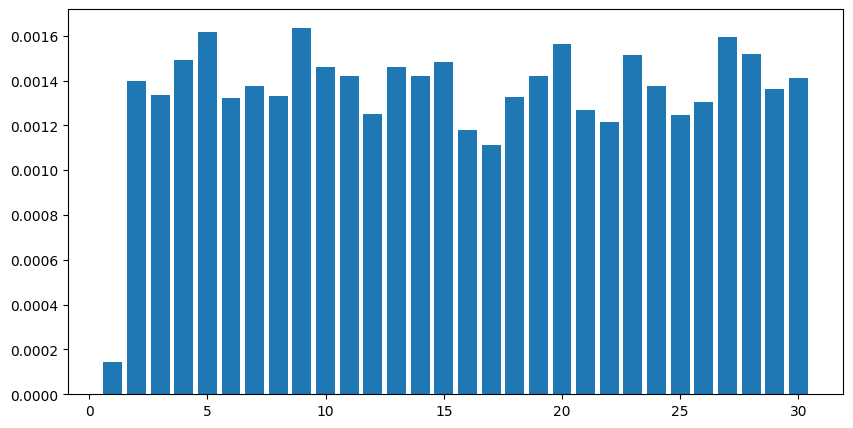

In [219]:
weights = parallel_agent.value_net.linear_layer.weight[0]
binned_weights = weights.reshape(30, weights.numel() // 30)
weight_group_magnitudes = binned_weights.abs().mean(dim=1).detach().numpy()

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(weight_group_magnitudes) + 1), weight_group_magnitudes)

<BarContainer object of 30 artists>

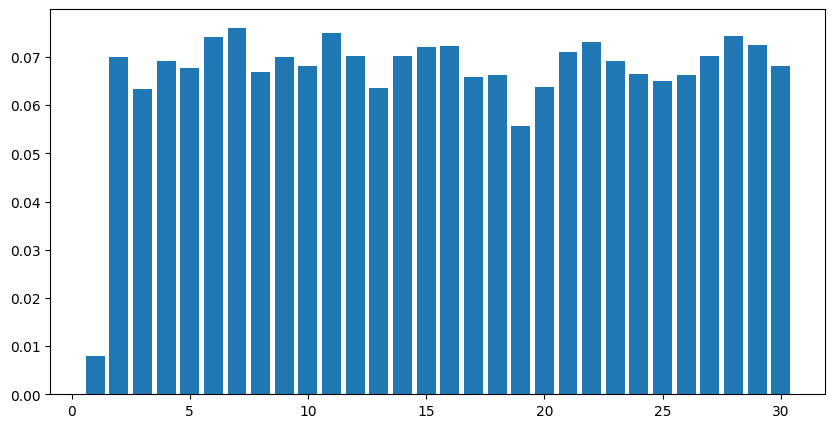

In [198]:
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(weight_group_magnitudes) + 1), weight_group_magnitudes)

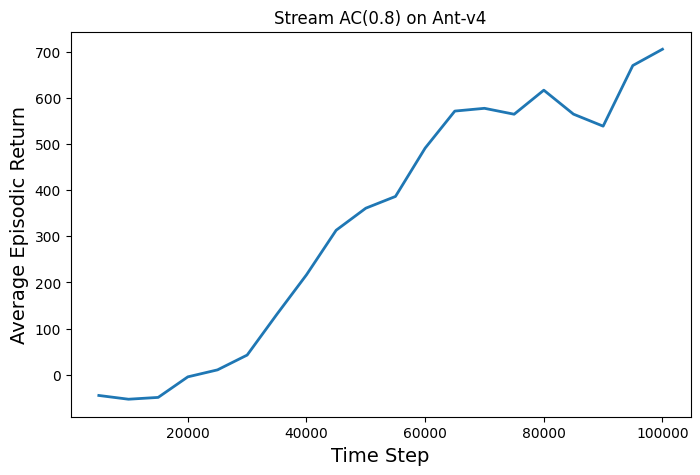

In [7]:
def avg_return_curve(x, y, stride, total_steps):
    assert len(x) == len(y)
    num_runs = len(x)
    avg_ret = np.zeros(total_steps // stride)
    stderr_ret = np.zeros(total_steps // stride)
    avg_ret2 = np.zeros(total_steps // stride)
    stderr_ret2 = np.zeros(total_steps // stride)
    steps = np.arange(stride, total_steps + stride, stride)
    num_rets = np.zeros(total_steps // stride)
    individ_avg_rets_per_run = []
    for i in range(0, total_steps // stride):
        rets = []
        avg_rets_per_run = []
        for run in range(num_runs):
            xa = np.array(x[run])
            ya = np.array(y[run])
            rets.append(ya[np.logical_and(i * stride < xa, xa <= (i + 1) * stride)].tolist())
            avg_rets_per_run.append(np.mean(rets[-1]))
        individ_avg_rets_per_run.append(avg_rets_per_run)
        flat_rets = np.array([ret for l in rets for ret in l])
        num_rets[i] = flat_rets.shape[0]
        avg_ret[i] = flat_rets.mean()
        stderr_ret[i] = flat_rets.std() / np.sqrt(num_rets[i])
        avg_ret2[i] = np.mean(avg_rets_per_run)
        stderr_ret2[i] = np.std(avg_rets_per_run) / np.sqrt(num_runs)
    return steps, avg_ret, stderr_ret, num_rets, avg_ret2, stderr_ret2, individ_avg_rets_per_run

def plot(data_dir, int_space, total_steps):
    plt.figure(figsize=(8, 5))
    all_termination_time_steps, all_episodic_returns, env_name = [], [], ''
    for file in os.listdir(data_dir):
        if file.endswith(".pkl"):
            with open(os.path.join(data_dir, file), "rb") as f:
                episodic_returns, termination_time_steps, env_name = pickle.load(f)
                all_termination_time_steps.append(termination_time_steps)
                all_episodic_returns.append(episodic_returns)

    (
        steps,
        avg_ret,
        stderr_ret,
        num_rets,
        avg_ret2,
        stderr_ret2,
        individ_avg_rets_per_run,
    ) = avg_return_curve(all_termination_time_steps, all_episodic_returns, int_space, total_steps)

    plt.plot(steps, avg_ret2, linewidth=2.0)
    plt.fill_between(steps, avg_ret2 - stderr_ret2, avg_ret2 + stderr_ret2, alpha=0.4)

    plt.xlabel("Time Step", fontsize=14)
    plt.ylabel(f"Average Episodic Return", fontsize=14)
    plt.title(r"Stream AC(0.8) on Ant-v4")
    plt.show()

plot(data_dir='data_stream_ac_Ant-v4', int_space=5_000, total_steps=100_000)

In [ ]:
m

In [ ]:
import imageio
# Save as a GIF
gif_path = '/content/Ant-v4.gif'
imageio.mimsave(gif_path, frames, format='GIF', fps=8)
# Display the GIF
from IPython.display import Image
Image(gif_path)